In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
pd.set_option('display.max_columns', None)
import filter_function as ff


In [3]:
#Loading the dataset

df=pd.read_excel('SharkAttack.xlsx')
df.head()

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatal Y/N,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2025-02-22 00:00:00,2025.0,Unprovoked,Australia,Western Australia,Blasck Wall Reach Swan River Perth,Kayaking,Georgina Smith,F,35,None kayak badly damaged by shark,N,0815hrs,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-22 00:00:00,2025.0,Questionable,Australia,NSW,Off Port Stephens near Newcastle,Fishing was pulled of boat by shark,Paul Barning,M,58,Body not recovered,Y,1300hrs,Mako shark,Simon De Marchi: Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-22 00:00:00,2025.0,Unprovoked,Australia,Queensland,The Wrecks walking track Moreton Island,Snorkeling,Unknown Male,M,29,Abdominal and leg injuries,N,1503hrs,Not stated,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-10 00:00:00,2025.0,Unprovoked,Bahamas,NaN,Bimini Bay,Swimming,Summer Layman,F,24,Left foot injured,N,1830hrs,bull shark,Dail Mail Australia Todd Smith: Kevin McMurray...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-10 00:00:00,2025.0,Unprovoked,Bahamas,NaN,Bimini Bay,Swimming,Rileigh Decker,F,20,Severed archilles tendon artery severed nerves...,N,1830hrs,bull shark,Dail Mail Australia Todd Smith: Kevin McMurray...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Cleaning/formating of column "Country"

# Cleaning
df["Country"] = (df["Country"].astype(str)
                  .str.lower()
                  .str.replace("&", "and", regex=False)
                  .str.replace(r"\.", "", regex=True)  
                  .str.replace(r"\s{2,}", " ", regex=True)  
                  .str.strip())  

# Changing of entries based on mapping dictionary
replace_dict = {
    r"between portugal and india": "unknown",
    r"andaman / nicobar islandas": "andaman islands",
    r"^ceylon \(sri lanka\)$": "sri lanka",
    r"ceylon": "sri lanka",
    r"colombia": "columbia",
    r"maldive islands": "maldives",
    r"solomon islands / vanuatu": "solomon islands",
    r"st\. maartin": "st martin",
    r"north atlantic ocean": "atlantic ocean",
    r"mid atlantic ocean": "atlantic ocean",
    r"south atlantic ocean": "atlantic ocean",
    r"north sea": "atlantic ocean",
    r"caribbean sea": "atlantic ocean",
    r"mediterranean sea": "atlantic ocean",
    r"north pacific ocean": "pacific ocean",
    r"south pacific ocean": "pacific ocean",
    r"central pacific": "pacific ocean",
    r"coral sea": "pacific ocean",
    r"south china sea": "pacific ocean",
    r"tasman sea": "pacific ocean",
    r"^british isles$": "england",
    r"^st helena, british overseas territory$": "st helena",
    r"^admiralty islands$": "papua new guinea",
    r"^british virgin islands$": "antigua",
    r"^british west indies$": "turks and caicos",
    r"^british overseas territory$": "turks and caicos",
    r"^tobago$": "trinidad and tobago",
    r"southwest pacific ocean": "pacific ocean",
    r"^ocean$": "pacific ocean",
    r"mid-pacifc ocean": "pacific ocean",
    r"^sudan\?$": "indian ocean",
    r"red sea / indian ocean": "indian ocean",
    r"northern arabian sea": "indian ocean",
    r"red sea": "indian ocean",
    r"gulf of aden": "indian ocean",
    r"persian gulf": "indian ocean",
    r"bay of bengal": "indian ocean",
    r"andaman islands": "india",
    r"coast of africa": "atlantic ocean",
    r"crete": "greece",
    r"^egypt / israel$": "egypt",
    r"^indian ocean\?$": "unknown",
    r"^asia\?$": "unknown",
    r"^africa$": "unknown",
    r"^american samoa$": "samoa",
    r"^western samoa$": "samoa",
    r"^equatorial guinea / cameroon$": "guinea",
    r"^reunion$": "reunion island",
    r"^british new guinea$": "papua new guinea",
    r"^new britain$": "papua new guinea",
    r"^italy / croatia$": "croatia",
    r"^iran / iraq$": "iran",
    r"^federated states of micronesia$": "micronesia",
    r"^st kitts / nevis$": "nevis",
    r"^united arab emirates \(uae\)$": "united arab emirates",
    r"^trinidad$": "trinidad and tobago",  
    r"^sri lanka \(sri lanka\)$": "sri lanka", 
    r"british nan territory": "united kingdom", 
}

In [5]:
# Wende alle Ersetzungen mit Regex an
df["Country"] = df["Country"].replace(replace_dict, regex=True)

# Extrahiere Ozeane und setze das Feld 'Ocean'
df["Ocean"] = df["Country"].apply(lambda x: x if isinstance(x,str) and "ocean" in x.lower() else "unknown")

# Entferne Ozeane aus der Country-Spalte
df["Country"] = df["Country"].replace({"indian ocean": "unknown", "atlantic ocean": "unknown", "pacific ocean": "unknown"})

# Entferne führende und nachfolgende Leerzeichen
df["Country"] = df["Country"].str.strip()

In [6]:
# Bereinigung und Umwandlung der 'Country'-Spalte
df["Country"] = (df["Country"].astype(str)
                  .str.lower()
                  .str.replace("&", "and", regex=False)
                  .str.replace(r"\.", "", regex=True)  # Entfernt Punkte
                  .str.replace(r"\s{2,}", " ", regex=True)  # Entfernt doppelte Leerzeichen
                  .str.strip())  # Entfernt führende/folgende Leerzeichen

df["Ocean"] = df["Country"].apply(lambda x: x if "ocean" in x.lower() else "unknown")

ocean_mapping = {
    "Pacific Ocean": [
        "australia", "fiji", "french polynesia", "guam", "hawaii", "indonesia", "japan", "kiribati",
        "marshall islands", "micronesia", "new caledonia", "new zealand", "northern mariana islands",
        "palau", "papua new guinea", "philippines", "samoa", "solomon islands", "tonga", "tuvalu",
        "vanuatu", "russia", "chile", "peru", "ecuador", "taiwan", "south korea"
    ],
    "Atlantic Ocean": [
        "algeria", "angola", "antigua", "argentina", "aruba", "azores", "bahamas", "barbados", "brazil",
        "canada", "cape verde", "cayman islands", "columbia", "costa rica", "cuba", "dominican republic",
        "england", "falkland islands", "france", "gabon", "georgia", "ghana", "grand cayman", "greenland",
        "grenada", "guyana", "haiti", "iceland", "ireland", "jamaica", "liberia", "mauritius", "mexico",
        "morocco", "namibia", "netherlands antilles", "nevis", "nicaragua", "nigeria", "norway", "panama",
        "paraguay", "portugal", "puerto rico", "senegal", "sierra leone", "south africa", "spain",
        "suriname", "trinidad and tobago", "tunisia", "turkey", "united kingdom", "uruguay", "usa",
        "venezuela", "west indies"
    ],
    "Indian Ocean": [
        "bangladesh", "comoros", "diego garcia", "djibouti", "egypt", "india", "iran", "kenya", "madagascar",
        "maldives", "mauritius", "mayotte", "mozambique", "oman", "reunion island", "seychelles", "somalia",
        "sri lanka", "tanzania", "thailand", "united arab emirates", "yemen"
    ]
}

def assign_ocean(country):
    for ocean, countries in ocean_mapping.items():
        if country in countries:
            return ocean
    return "unknown"  


df["Ocean"] = df["Country"].apply(lambda x: assign_ocean(x) if pd.notnull(x) else "unknown")

In [7]:
# Create column "Hemisphere"
hemisphere_mapping = {
    "Northern Hemisphere": [
        "algeria", "antigua", "bahamas", "bahrein", "bangladesh", "barbados", "belize", "bermuda", "burma",
        "canada", "china", "columbia", "costa rica", "croatia", "cuba", "cyprus", "denmark", "dominican republic",
        "ecuador", "egypt", "el salvador", "england", "france", "georgia", "greece", "guatemala", "haiti",
        "honduras", "iceland", "india", "iran", "iraq", "ireland", "israel", "italy", "jamaica", "japan",
        "jordan", "korea", "kuwait", "lebanon", "mexico", "monaco", "montenegro", "morocco", "netherlands",
        "nevis", "nicaragua", "nigeria", "norway", "palestine", "panama", "portugal", "russia", "san domingo",
        "saudi arabia", "senegal", "slovenia", "south korea", "spain", "sudan", "sweden", "syria", "the balkans",
        "trinidad and tobago", "tunisia", "turkey", "united arab emirates", "united kingdom", "usa", "vietnam", "yemen"
    ],
    "Southern Hemisphere": [
        "angola", "argentina", "australia", "brazil", "chile", "comoros", "fiji", "independent samoa",
        "indonesia", "kiribati", "liberia", "madagascar", "malawi", "mauritius", "mozambique", "namibia",
        "new zealand", "papua new guinea", "paraguay", "peru", "seychelles", "solomon islands", "south africa",
        "tanzania", "tonga", "tuvalu", "uruguay", "vanuatu"
    ],
    "Equatorial Area": [
        "cape verde", "caribbean region", "djibouti", "gabon", "ghana", "guinea", "guyana", "kenya",
        "malaysia", "maldives", "marshall islands", "micronesia", "panama", "philippines", "singapore",
        "somalia", "sri lanka", "suriname", "thailand", "venezuela"
    ]
}

def assign_hemisphere(country):
    for hemisphere, countries in hemisphere_mapping.items():
        if country in countries:
            return hemisphere
    return "unknown"  

df["Hemisphere"] = df["Country"].str.lower().apply(assign_hemisphere)

print(df[["Country", "Hemisphere"]])


        Country           Hemisphere
0     australia  Southern Hemisphere
1     australia  Southern Hemisphere
2     australia  Southern Hemisphere
3       bahamas  Northern Hemisphere
4       bahamas  Northern Hemisphere
...         ...                  ...
6999  australia  Southern Hemisphere
7000  australia  Southern Hemisphere
7001        usa  Northern Hemisphere
7002     panama  Northern Hemisphere
7003  sri lanka      Equatorial Area

[7004 rows x 2 columns]


In [8]:
df.shape

(7004, 25)

In [9]:
#Cleaning the column Fatal 
df["Fatal Y/N"] = df["Fatal Y/N"].str.strip()
df["Fatal Y/N"] = df["Fatal Y/N"].str.lower()
df["Fatal Y/N"] = df["Fatal Y/N"].replace({"f": "y", "m": "y", "nan": "n", "nq": "n", "unknown": "unknown", "y x 2": "y"})
df["Fatal Y/N"] = df["Fatal Y/N"].fillna("unknown")

df['Fatal Y/N'].unique()

array(['n', 'y', 'unknown'], dtype=object)

In [10]:
#Counting the Fatal, Non-Fatal,Unknown incidents
fatal_counts=df['Fatal Y/N'].value_counts()
print(fatal_counts)


Fatal Y/N
n          4887
y          1484
unknown     633
Name: count, dtype: int64


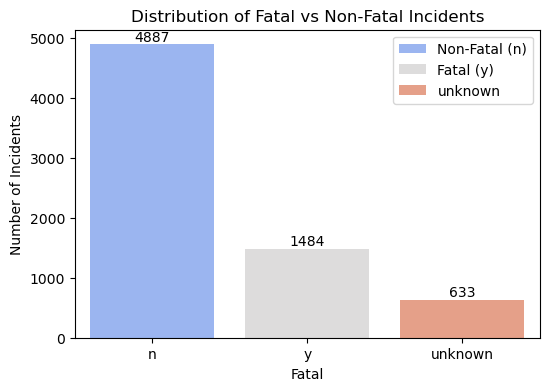

In [11]:
#Visualizing the Fatal column

# Plot the distribution of fatal incidents
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Fatal Y/N', hue='Fatal Y/N', palette='coolwarm', legend=False)
ax.legend( loc='upper right', labels=['Non-Fatal (n)', 'Fatal (y)','unknown'])

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Distribution of Fatal vs Non-Fatal Incidents')
plt.xlabel('Fatal')
plt.ylabel('Number of Incidents')
plt.show()

In [12]:
#Cleaning the Activity column

df['Activity']=df['Activity'].fillna('unknown') #Filling missing values
df['Activity']=df['Activity'].str.lower().str.strip() #Standardizing the text

# Applyinbg the categorization function
df['Activity'] = df['Activity'].apply(ff.categorize_activity)

# Verifying the results
print(df['Activity'].value_counts())

# Save the cleaned dataset
#df.to_excel('cleaned_shark_attacks.xlsx', index=False)


Activity
swimming            1863
surfing             1634
fishing             1272
other activities     698
diving               673
unknown              589
watercraft           275
Name: count, dtype: int64


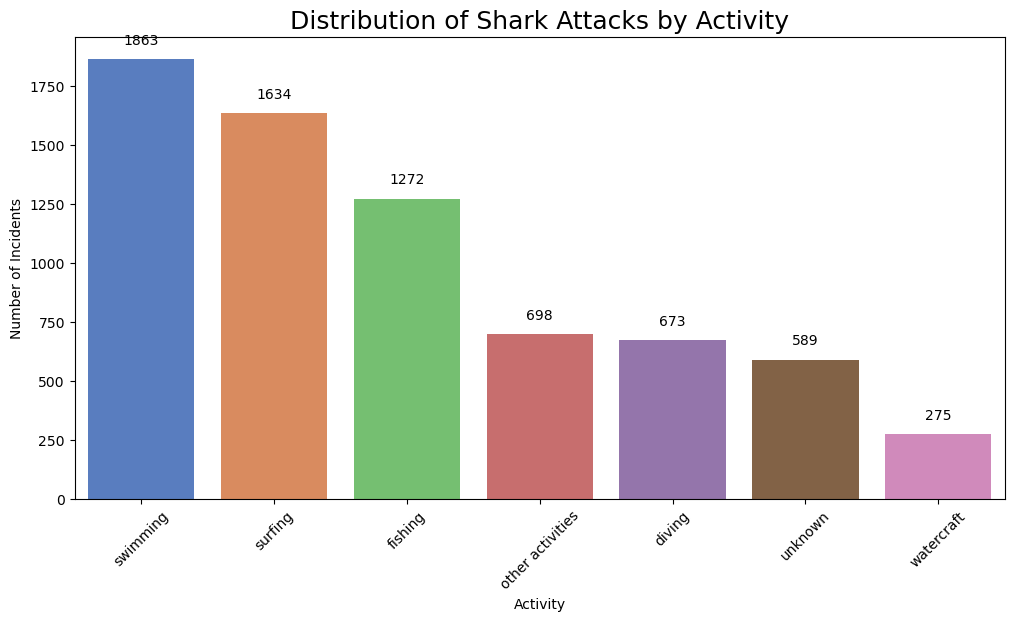

In [ ]:
# Plot the distribution of activities (Bar Plot)
plt.figure(figsize=(12, 6))
activity_counts = df['Activity'].value_counts()
ax = sns.barplot(x=activity_counts.index, y=activity_counts.values, hue=activity_counts.index,palette='muted')

# Annotations
for i, count in enumerate(activity_counts):
    ax.text(i, count + 50, f'{count}', ha='center', va='bottom')

plt.title('Distribution of Shark Attacks by Activity', fontsize=18)
plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

In [12]:
#Proportion of shark attacks by activity
activity_proportions = df['Activity'].value_counts(normalize=True) * 100
print(activity_proportions)


Activity
swimming            26.599086
surfing             23.329526
fishing             18.161051
other activities     9.965734
diving               9.608795
unknown              8.409480
watercraft           3.926328
Name: proportion, dtype: float64


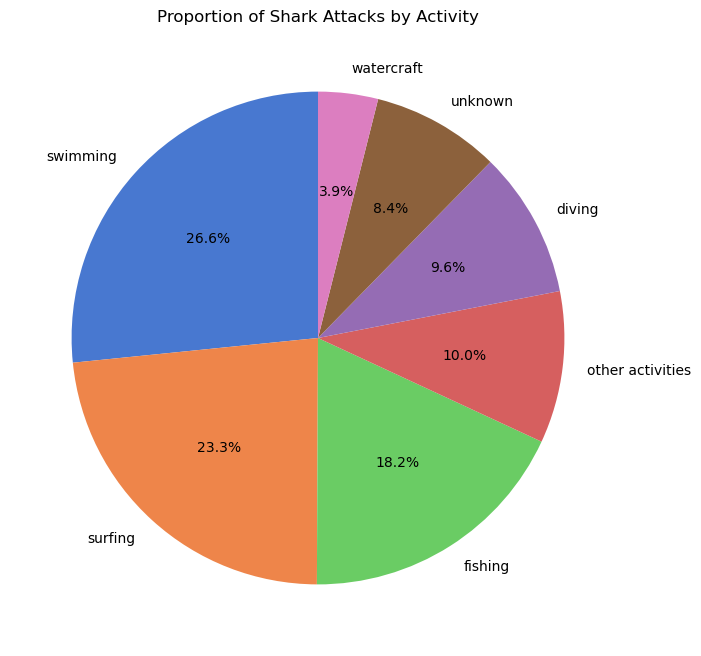

In [13]:
#Visualizing the activity counts
# Plot the distribution of activities (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(activity_proportions, labels=activity_proportions.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'))
plt.title('Proportion of Shark Attacks by Activity')
plt.show()

In [21]:
#The relationship of between activities and fatal incidents
activity_fatal = pd.crosstab(df['Activity'], df['Fatal Y/N'])
activity_fatal

Fatal Y/N,n,unknown,y
Activity,,,
diving,464,69,140
fishing,1016,80,176
other activities,374,75,249
surfing,1438,65,131
swimming,1138,150,575
unknown,312,166,111
watercraft,145,28,102


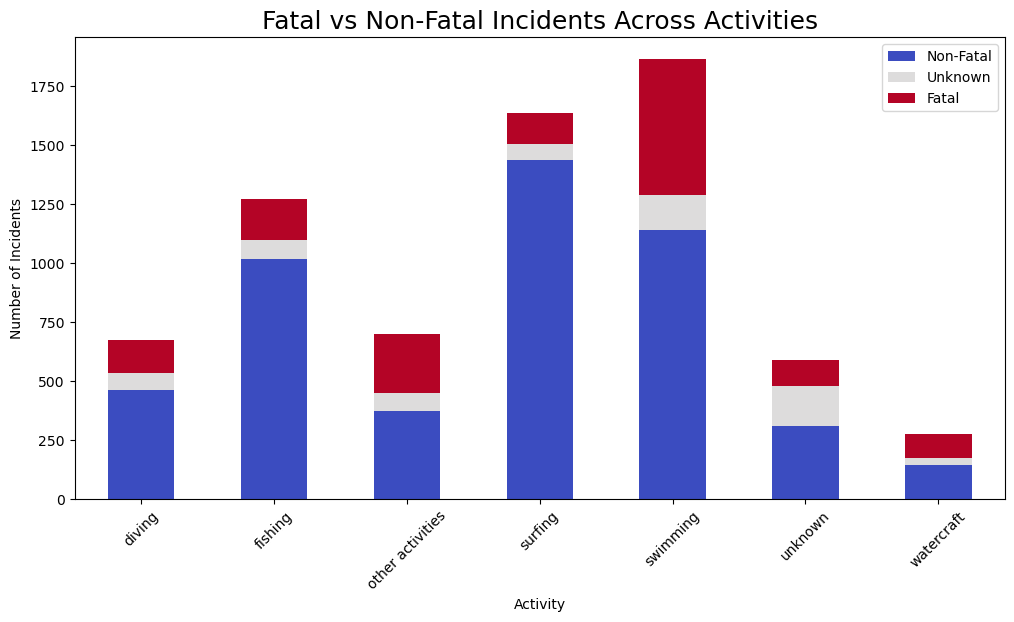

In [16]:
# Plot the relationship (Stacked Bar Plot)
activity_fatal.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Fatal vs Non-Fatal Incidents Across Activities', fontsize=18)

plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(loc='upper right',labels=['Non-Fatal', 'Unknown', 'Fatal', ])

plt.show()

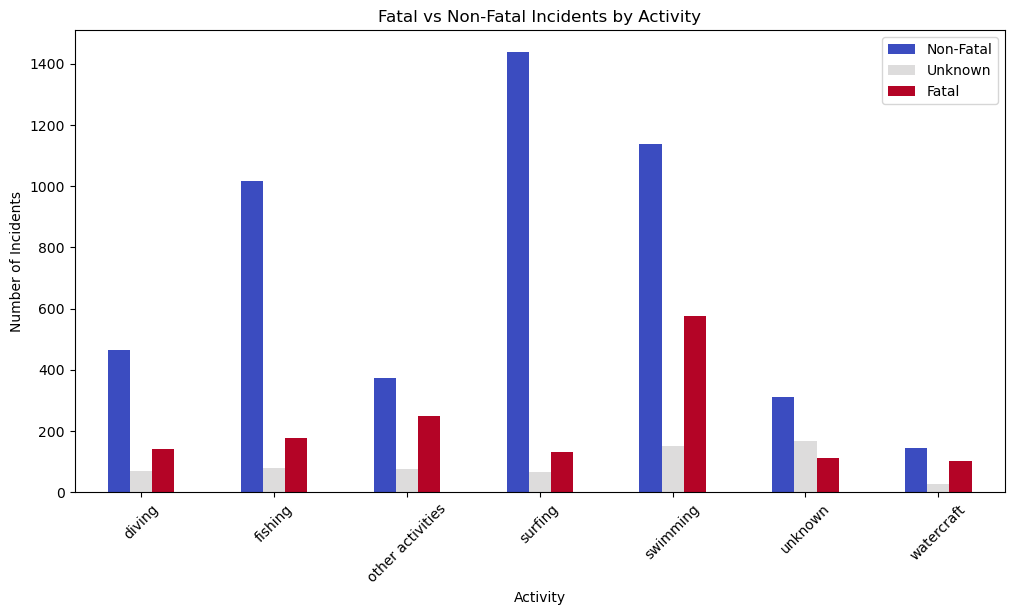

In [17]:
# Plot the relationship (Grouped Bar Plot)
activity_fatal.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')  
plt.title('Fatal vs Non-Fatal Incidents by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend( loc='upper right', labels=['Non-Fatal','Unknown','Fatal'])
plt.show()

In [18]:
#Ranking the activities by fatal incidents
activity_fatal['fatal_incidents'] = activity_fatal['y']
activity_fatal_sorted = activity_fatal.sort_values(by='fatal_incidents', ascending=False)
activity_fatal_sorted

Fatal Y/N,n,unknown,y,fatal_incidents
Activity,,,,
swimming,1138,150,575,575
other activities,374,75,249,249
fishing,1016,80,176,176
diving,464,69,140,140
surfing,1438,65,131,131
unknown,312,166,111,111
watercraft,145,28,102,102


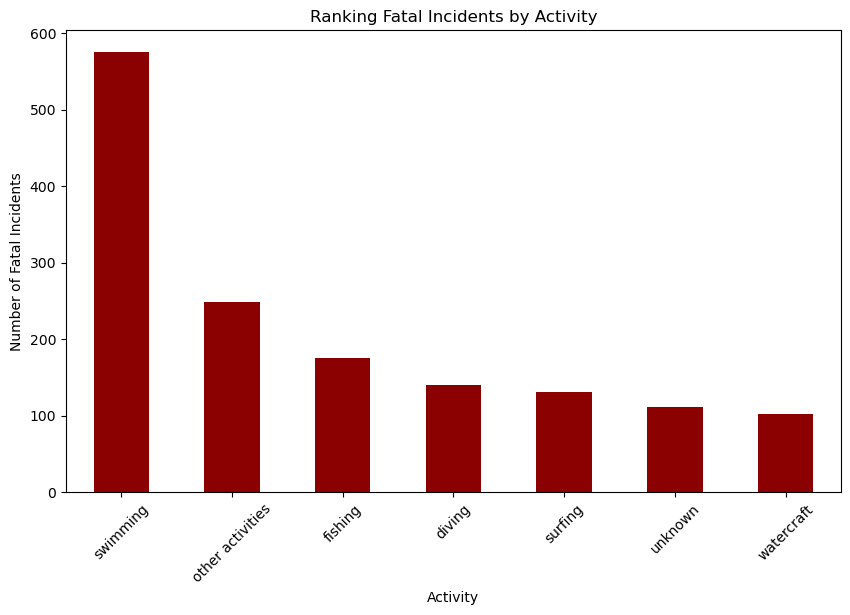

In [19]:
# Plotting the bar chart for ranking
plt.figure(figsize=(10, 6))
activity_fatal_sorted['fatal_incidents'].plot(kind='bar', color='darkred')
plt.title('Ranking Fatal Incidents by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Fatal Incidents')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Proportion of Fatal Incidents by Activity
# Filter for activities with at least one fatal incident
fatal_activities = activity_fatal_sorted[activity_fatal_sorted['y'] > 0]

# Count the number of fatal incidents per activity
fatal_counts = fatal_activities['fatal_incidents']

# Total fatal incidents across all activities
total_fatal_incidents = fatal_counts.sum()

# Calculate the percentage of fatal incidents per activity
fatal_activities["Percentage"] = ((fatal_counts / total_fatal_incidents) * 100).round(2)

# Select only the necessary columns
fatal_activities_filtered = fatal_activities[['fatal_incidents', 'Percentage']]

# Display the cleaned-up DataFrame
fatal_activities_filtered

Fatal Y/N,fatal_incidents,Percentage
Activity,,
swimming,575,38.75
other activities,249,16.78
fishing,176,11.86
diving,140,9.43
surfing,131,8.83
unknown,111,7.48
watercraft,102,6.87


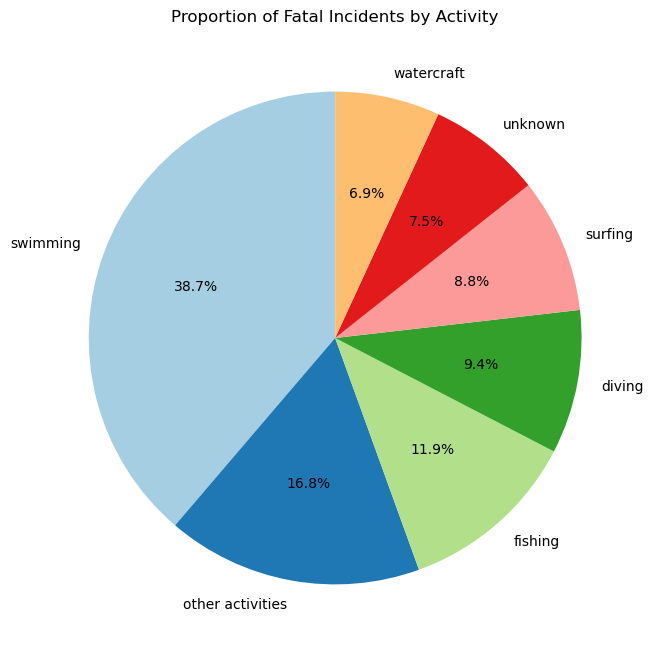

In [21]:
#Visualization
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(fatal_counts, labels=fatal_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Set the title
plt.title('Proportion of Fatal Incidents by Activity')

# Display the pie chart
plt.show()

In [22]:
# Creating the table for Total incidents and Fatal incidents in ascending order
result = activity_fatal[['n', 'fatal_incidents']].sort_values(by='fatal_incidents', ascending=False)

# Display the result
result.rename(columns={'n': 'Total Incidents', 'fatal_incidents': 'Fatal Incidents'}, inplace=True)
result

Fatal Y/N,Total Incidents,Fatal Incidents
Activity,,
swimming,1138,575
other activities,374,249
fishing,1016,176
diving,464,140
surfing,1438,131
unknown,312,111
watercraft,145,102


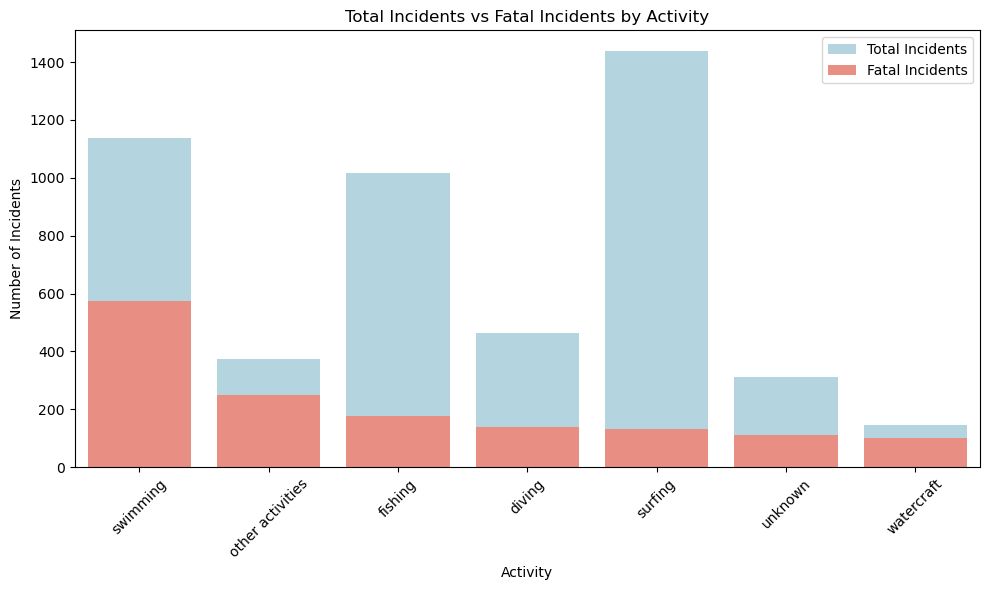

In [23]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x=result.index, y='Total Incidents', data=result, color='lightblue', label='Total Incidents')
sns.barplot(x=result.index, y='Fatal Incidents', data=result, color='salmon', label='Fatal Incidents')

# Adding labels and title
plt.title('Total Incidents vs Fatal Incidents by Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [24]:
#Conduct a Chi-square test to determine if the fatal incidents distribution is independent of the activites.
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(activity_fatal)

chi2_statistic, chi2_p_value

print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {chi2_p_value}")

Chi-square Statistic: 1140.5945756503293
P-value: 5.921737442683314e-231


In [25]:
# Computing the association between variables in 'activity_fatal' using the "cramer" method
cramer_method = association(activity_fatal, method="cramer")

print(f"Cramér's V: {cramer_method}")

Cramér's V: 0.21164223450089972


### Chi-square Test Results:
- **Chi-square statistic:** 1140.59
- **P-value:** 5.92e-231

### Interpretation of the Chi-square Test:
- **Assumption:** The distribution of fatal incidents is independent of the activity.
- **Testable Idea (H₁):** The distribution of fatal incidents is dependent on the activity.

Since the **p-value** (5.92e-231) is extremely small and much smaller than the typical significance level of 0.05, the **null hypothesis** (independence between activity and fatal incidents) can be **rejected** with high confidence. This means that there is **strong evidence** suggesting that the distribution of fatal incidents **is dependent on the activity**. In other words, the occurrence of fatal incidents is influenced by the type of activity.

### Cramér's V:
- **Cramér's V value:** 0.2116

The Cramér's V value of **0.2116** indicates a **weak to moderate association** between activities and fatal incidents, meaning that the type of activity does have a noticeable effect on the occurrence of fatal incidents, but the association is not extremely strong.

### Final Conclusion:
- The **Chi-square test** provides **strong evidence** that the distribution of fatal incidents is dependent on the activity.
- The **Cramér's V** suggests a **weak to moderate association**, indicating that some activities are more closely linked with fatal incidents, but not to the point of being very strongly dependent on one another.

In [27]:
df["Year"] = df["Year"].fillna(0).astype(int)
df["Year"].value_counts()
# create month from Date - by Sergej
df['Date'] = df['Date'].astype(str)
df.insert(2, "month",df['Date'].apply(lambda x: ff.extract_month(x)))
# create season from month - by Sergej
df.insert(3, "season",df['month'].apply(lambda x:ff.month_to_season(x)))

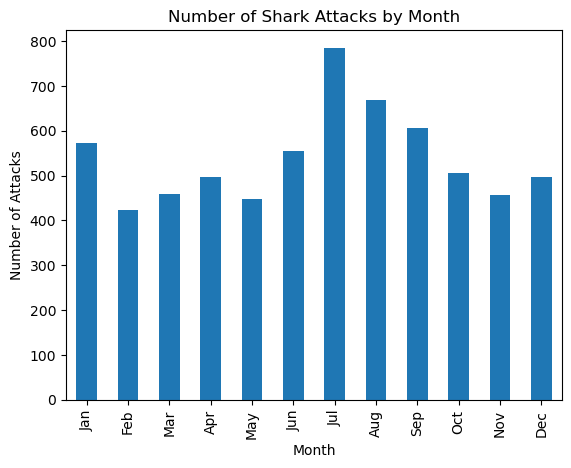

In [28]:
monthly_attacks = df[((df["month"] < 13) & (df["month"] > 0))].groupby('month').size()
# Plotting the graph
monthly_attacks.plot(kind='bar', ) # bar chart
plt.title('Number of Shark Attacks by Month')
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # X-axis labels
plt.show()

In [29]:
# Top 10 countries with the highest chance of shark attacks
# Total shark attacks worldwide
total_attacks = len(df)

df_filtered = df[df["Country"] != "unknown"]

# calculation of shark attacks per country
country_attack_counts = df_filtered["Country"].value_counts()
# calculation of percentage of shark attacks per country
country_attack_percentage = ((country_attack_counts / total_attacks) * 100).round(0)

# table
top_10_countries = (
    pd.DataFrame({
        "Country": country_attack_counts.index,
        "Shark Attacks": country_attack_counts.values,
        "Percentage of Global Attacks": country_attack_percentage.values
    })
    .head(10)  # Select only the top 10 countries
)

print(top_10_countries)


            Country  Shark Attacks  Percentage of Global Attacks
0               usa           2556                          36.0
1         australia           1497                          21.0
2      south africa            598                           9.0
3       new zealand            146                           2.0
4  papua new guinea            144                           2.0
5           bahamas            139                           2.0
6            brazil            122                           2.0
7            mexico            106                           2.0
8             italy             72                           1.0
9              fiji             70                           1.0


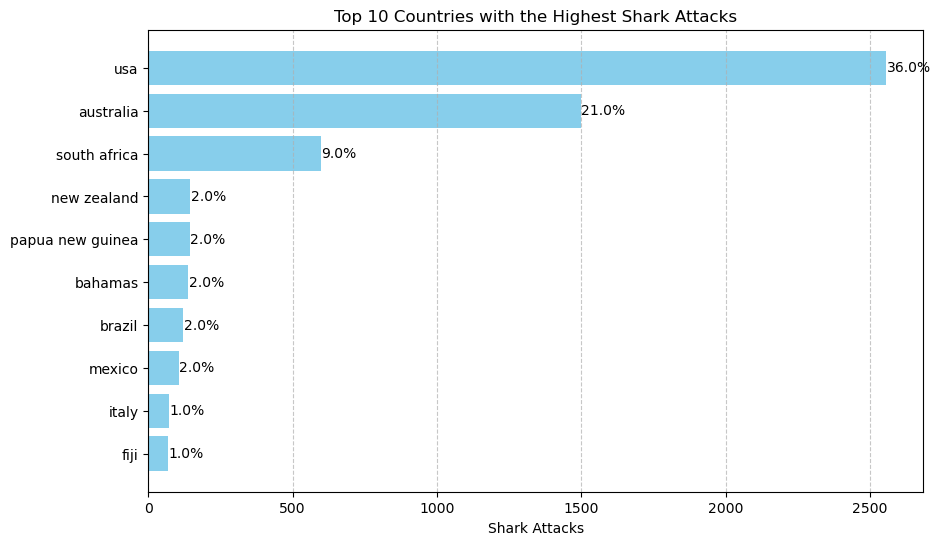

In [30]:
# Create a bar plot for the top 10 countries with the highest shark attacks
plt.figure(figsize=(10, 6))
plt.barh(top_10_countries["Country"], top_10_countries["Shark Attacks"], color='skyblue')
plt.xlabel('Shark Attacks')
plt.title('Top 10 Countries with the Highest Shark Attacks')
plt.gca().invert_yaxis()  # To have the country with the highest attacks at the top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Add percentage labels on the bars
for i, v in enumerate(top_10_countries["Shark Attacks"]):
    plt.text(v + 1, i, f"{top_10_countries['Percentage of Global Attacks'].iloc[i]}%", va='center')

plt.show()

In [31]:
# Top 10 countries with the highest risk of fatale shark attacks

df_filtered = df_filtered[df_filtered["Fatal Y/N"].isin(["y", "n"])]

# Calculation of fatale attacks per country
fatal_attack_counts = df_filtered[df_filtered["Fatal Y/N"] == "y"]["Country"].value_counts()

# calculation of fatale attacks per country in percentage
fatal_attack_percentage = ((fatal_attack_counts / total_attacks) * 100).round(0)

# table top 10
top_10_fatal_countries = (
    pd.DataFrame({
        "Country": fatal_attack_counts.index,
        "Fatal Shark Attacks": fatal_attack_counts.values,
        "Percentage of Global Fatal Attacks": fatal_attack_percentage.values
    })
    .head(10) 
)

print(top_10_fatal_countries)

            Country  Fatal Shark Attacks  Percentage of Global Fatal Attacks
0         australia                  307                                 4.0
1               usa                  200                                 3.0
2      south africa                  110                                 2.0
3  papua new guinea                   62                                 1.0
4            mexico                   49                                 1.0
5            brazil                   39                                 1.0
6       philippines                   37                                 1.0
7    reunion island                   34                                 0.0
8              cuba                   26                                 0.0
9     new caledonia                   26                                 0.0


In [32]:
# Ranking of oceans with highest chance of shark attacks

# Calaculation of shark attacks for each ocean
ocean_attack_counts = df_filtered["Ocean"].value_counts()

# calculation of percentage of shark attacks per ocean
ocean_attack_percentage = ((ocean_attack_counts / total_attacks) * 100).round(0)

# table
ranking_oceans = (
    pd.DataFrame({
        "Ocean": ocean_attack_counts.index,
        "Shark Attacks": ocean_attack_counts.values,
        "Percentage of Global Attacks": ocean_attack_percentage.values
    })
    .head()
)

print(ranking_oceans)

            Ocean  Shark Attacks  Percentage of Global Attacks
0  Atlantic Ocean           3564                          51.0
1   Pacific Ocean           2058                          29.0
2         unknown            336                           5.0
3    Indian Ocean            312                           4.0


In [33]:
# Ranking of oceans with highest chance of fatale shark attacks

# remove unknown from ocean column and unknown from Fatale Column
df_filtered = df[df["Ocean"] != "unknown"]
df_filtered = df_filtered[df_filtered["Fatal Y/N"].isin(["y", "n"])]

# Calculation of fatale attacks per ocean
fatal_attack_counts = df_filtered[df_filtered["Fatal Y/N"] == "y"]["Ocean"].value_counts()

# calculation of fatale attacks per ocean in percentage
fatal_attack_percentage = ((fatal_attack_counts / total_attacks) * 100).round(0)

ranking_fatale_oceans = (
    pd.DataFrame({
        "Ocean": fatal_attack_counts.index,
        "Fatal Shark Attacks": fatal_attack_counts.values,
        "Percentage of Global Fatal Attacks": fatal_attack_percentage.values
    })
    .head()
)

print(ranking_fatale_oceans)

            Ocean  Fatal Shark Attacks  Percentage of Global Fatal Attacks
0   Pacific Ocean                  571                                 8.0
1  Atlantic Ocean                  568                                 8.0
2    Indian Ocean                  155                                 2.0
